In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive


E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [ ]:
cd /content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work

/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work


In [ ]:
!pip install rasterio rasterstats fiona geopandas
#import required libraries
import rasterio
import pylab
from rasterio import plot
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import pandas as pd
from pyproj import CRS
import osr
import ogr
import gdal
import glob
from shapely.geometry import mapping
from rasterio.mask import mask
import numpy as np
import matplotlib
import math
import os
from rasterstats import zonal_stats
from datetime import datetime


     |████████████████████████████████| 19.3 MB 15.0 MB/s 
     |████████████████████████████████| 16.7 MB 72.4 MB/s 
     |████████████████████████████████| 1.0 MB 65.5 MB/s 
     |████████████████████████████████| 130 kB 62.3 MB/s 
     |████████████████████████████████| 6.3 MB 58.7 MB/s 


In [ ]:
path = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work'
pathim = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/data/images/hot_dry_season/dagana'

In [ ]:
#==========================================================================
#==========================================================================
mndwi_path = pathim + '/2021/mndwi'
boundary_path = path +'/data/boundaries/dagana2.geojson'
s2cloudless_path = pathim +'/2021/cloud'
reference_image_path =pathim+'/2021/mndwi/mndwi_2021-01-02.tif' 
rgb_img = pathim+'/2021/rgb/mndwi_2022-01-02.tif'

empty_array = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/data/images/hot_dry_season/dagana/2021/output/maps/test.tif'

grid_path = path +'/data/boundaries/grid_dagana/grid52_dagana.geojson'

# Generate the flooding df and the proportion df

> Indented block



In [ ]:
def create_flooding_prop_df (img,empty_array ,grid_path,listcloud, flooding_path, proportion_path,  savefile=True):

    #===========================================================================
    # Populate the grid boundary with the flooding area
    #==========================================================================
    date_list =  [img_name.split('_')[1].split('.')[0]  for img_name in listcloud] 
    dates ={}
    c = 2
    dates[0]= 'no-data'
    dates[1]= 'no-flooding'
    for d in date_list:
      dates[c] = d
      c+=1
    count_ref_img1 =zonal_stats(grid_path,img,categorical=True, category_map=dates)
    stat_df=pd.DataFrame(count_ref_img1)
    stat_df= stat_df.fillna(0)

    #===================================================================
    # Sort the dates
    #==================================================================
    def sort_dates (dates_str, format='%Y-%m-%d'): 
        # Sort data
        dates_obj =[ datetime.strptime(date_time_str, format) for date_time_str in dates_str]
        #  sorteddates = [datetime.strftime(ts, format) for ts in dates_obj]
        dates_obj.sort()
        return dates_obj
    date_str = sort_dates (stat_df.columns.to_list() [2:], format='%Y-%m-%d')   
    dates_st = [d.strftime("%Y-%m-%d") for d in date_str  ]

    #========================================== ==============================
    # Fill the df with the area size
    #=========================================================================
    count_ref_img0 =zonal_stats(grid_path, empty_array, categorical=True, category_map={1:'count'} )
    georead1 = gpd.read_file(grid_path) 
    size = pd.DataFrame(count_ref_img0)
    size.fillna(0)
    size  = size ['count']
    
    
    df = georead1.copy()
    df[dates_st] = stat_df[dates_st]
    df['total_area'] = size
    #==========================================================================
    # Generate the  exploitable surface by remove water ways from the total area
    #==========================================================================
    # don t consider this
    # df['farm_area'] = df['total_area'] - df[ dates_st [0]]


    # =====================================================================
    #generate cumulative flooding area 
    #======================================================================
    df_flooding = df.copy()
    list_ = dates_st[1:]
    for i  in range(len(list_)):
      df_flooding [list_[i] ] = df_flooding [ list_[i-1] ] + df_flooding [ list_[i] ]


    # =====================================================================
    # generate proportion 
    #======================================================================
    df_prop = df_flooding.copy()
    list_ = dates_st[1:]
    for i  in range(len(list_)):
      df_prop [list_[i] ] = df_flooding [ list_[i]] / df_prop['total_area']

    # df_prop['farm_area'] =  df_prop['farm_area'] *100*0.0001
    df_prop['total_area'] =  df_prop['total_area'] *100*0.0001
    df_prop [dates_st[0] ] =  df_prop [dates_st[0] ] *100*0.0001
    
    df_prop = df_prop.rename(columns={dates_st[0] :dates_st[0]+'_standing water'})

    df_prop.to_csv(proportion_path)


    # =====================================================================
    # Determine the flooding date 
    #======================================================================
    maxValueIndex1 = df[ dates_st[1:] ] .idxmax(axis=1)
    maxValues = df[ dates_st[1:] ].max(axis = 1)
    df_flooding['flooding_date'] = maxValueIndex1

    df_flooding[dates_st ] =  df_flooding[ dates_st ] *100*0.0001
    # df_flooding['farm_area'] = df_flooding['farm_area'] *100*0.0001
    df_flooding['total_area'] = df_flooding['total_area'] *100*0.0001
    df_flooding['total_flooded_area'] = df[ dates_st[1:]] .sum(axis=1)*100*0.0001
    # Rename the first acquisition date image
    df_flooding = df_flooding.rename(columns={dates_st[0] :dates_st[0]+'_standing water'})

    if savefile ==True:
      df_flooding.to_csv(flooding_path)

    df.to_csv()
    return df_flooding, df_prop

In [ ]:
# f, p = create_flooding_prop_df (img, empty_array, flooding_path, proportion_path)

# Generate the time series of strength

In [ ]:
count_ref_img0 =zonal_stats(grid_path, empty_array, categorical=True, category_map={1:'count'} )
size = pd.DataFrame(count_ref_img0)
çsize.fillna(0)
size  = size ['count']


In [ ]:
def generate_performance(listcloud, grid_path, path_= pathim +'/2021/cloud/', save_to= pathim+'/2021/output/files/timeseries2021_n.csv'):
  #============================================================
  # Populate the grid with the size 
  #===========================================================
  count_ref_img0 =zonal_stats(grid_path,path_+ listcloud[0])
  georead1 = gpd.read_file(grid_path) 
  df = georead1.copy()
  size = pd.DataFrame(count_ref_img0)['count']
  df['total_area'] = size
  
  #==================================================
  for img_name in  listcloud:
    date = img_name.split('_')[1].split('.')[0]
    pim = path_ +img_name
    count_ref_img1 =zonal_stats(grid_path, pim ,categorical=True)
    stat_df=pd.DataFrame(count_ref_img1)
    stat_df= stat_df.fillna(0)
    thresh = [i for i in stat_df.columns.to_list() if i < 40]
    df[date] = stat_df[thresh] .sum(axis=1)
    

    #====================GENERATE THE PROPORTION
  dates = [img_name.split('_')[1].split('.')[0]  for img_name in listcloud[1:]]
  
  df1 = georead1.copy()
  df1['total_area'] = size
  # df1['farm_area'] = df1['total_area'] - list_standing_water
  # populate df1 with the total area
  for d in dates:
    df1[d]= df1['total_area']
  df1[dates]  = df[dates]/df1[dates] *100
  df1['total_area'] = df1['total_area'] *100*0.0001
  # df1['total_area'] = df1['total_area'] *100*0.0001

  df1 = df1.rename(columns={dates[0] : dates[0]+'_standing water'})
  df1.to_csv(save_to)
  return df1

In [ ]:
#=================================================================================================
#                       UPDATE
#==============================================================================================
def generate_performance_up(listcloud, empty_array, grid_path,cloud_probability_threshold=40, path_= pathim +'/2021/cloud/', save_to= pathim+'/2021/output/files/timeseries2021_n.csv'):
  #============================================================
  # Populate the grid with the size 
  #===========================================================
      #========================================== ==============================
    # Fill the df with the area size
    #=========================================================================
  count_ref_img0 =zonal_stats(grid_path, empty_array, categorical=True, category_map={1:'count'} )
  georead1 = gpd.read_file(grid_path) 
  size = pd.DataFrame(count_ref_img0)
  size.fillna(0)
  size  = size ['count']

  georead1 = gpd.read_file(grid_path) 
  df = georead1.copy()
  # size = pd.DataFrame(count_ref_img0)['count']

  df['total_area'] = size
  #==================================================
  for img_name in  listcloud:
    date = img_name.split('_')[1].split('.')[0]
    pim = path_ +img_name
    count_ref_img1 =zonal_stats(grid_path,pim,categorical=True)
    stat_df=pd.DataFrame(count_ref_img1)
    stat_df= stat_df.fillna(0)
    # Select value greater than 0 as 0 is made of both the probability and the no-data
    threshold_ = [ i for i in stat_df.columns.to_list() if i > 0 ]
    # Count the number of pixels in with value greater than 0
    df['count'] = stat_df[ threshold_ ] .sum(axis=1)
    # Find the number of pixel with probability 0
    df['diff'] = df['total_area'] -  df['count'] 
    res_ = []
    for val in df['diff'].to_list():
      tmp = 0
      if val <0:  # Number of pixel with 0 > total_area 
        tmp = abs(val)
      if val > 0 :  #
        tmp = 0 
      res_.append(tmp)
    # Get the real number of 0 that is the probability
    df['diff_up'] = res_   
     # Define a new threshold
    threshold_up =  [ i for i in threshold_ if i < cloud_probability_threshold ]

    df[date] = stat_df[threshold_up] .sum (axis=1)  + df ['diff_up']

  #=============================
  # Save the file generate FOR PERSONAL PURPOSE
  #=============================
  #df.to_file()

  #====================GENERATE THE PROPORTION
  dates = [img_name.split('_')[1].split('.')[0]  for img_name in listcloud[1:]]
  df1 = georead1.copy()
  df1['total_area'] = size
  # df1['farm_area'] = df1['total_area'] - list_standing_water
  # populate df1 with the total area
  for d in dates:
    df1[d]= df1['total_area']
  df1[dates]  = df[dates]/df1[dates] *100
  df1['total_area'] = df1['total_area'] *100*0.0001
  # df1['total_area'] = df1['total_area'] *100*0.0001

  df1 = df1.rename(columns={dates[0] : dates[0]+'_standing water'})
  df1.to_csv(save_to)
  return df1



# Compute proportion and flooding

##2021

In [ ]:
listcloud21  = ['cloud_2021-01-02.tif',
 'cloud_2021-01-07.tif',
 'cloud_2021-01-12.tif',
 'cloud_2021-01-17.tif',
 'cloud_2021-01-22.tif',
 'cloud_2021-01-27.tif',
 'cloud_2021-02-01.tif',
 'cloud_2021-02-06.tif',
 'cloud_2021-02-11.tif',
 'cloud_2021-02-16.tif',
 'cloud_2021-02-21.tif',
 'cloud_2021-02-26.tif',
 'cloud_2021-03-03.tif',
 'cloud_2021-03-08.tif',
 'cloud_2021-03-13.tif',
 'cloud_2021-03-18.tif',
 'cloud_2021-03-23.tif',
 'cloud_2021-03-28.tif',
 'cloud_2021-04-02.tif',
 'cloud_2021-04-07.tif',
 'cloud_2021-04-12.tif',
 'cloud_2021-04-17.tif',
 'cloud_2021-04-22.tif',
 'cloud_2021-04-27.tif',
 'cloud_2021-05-02.tif',
 'cloud_2021-05-07.tif',
 'cloud_2021-05-12.tif',
 'cloud_2021-05-17.tif',
 'cloud_2021-05-22.tif',
 'cloud_2021-05-27.tif']

#================
# flooding and proportion
#==================
listcloud = listcloud21
img =pathim+'/2021/output/maps/flooding_maps2021_14.tif'
flooding_path ='/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/ANALYSIS_NDVI_vs_MNDWI/flooding_dagana2021.csv'
# pathim+'/2021/output/files/timeseries2021_flooding_update_2022-02-18.csv'
proportion_path = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/ANALYSIS_NDVI_vs_MNDWI/proportion_dagana2021.csv' 
#pathim+'/2021/output/files/timeseries2021_proportion_update_2022-02-18.csv'
reference_image_path =pathim+'/2021/mndwi/mndwi_2021-01-02.tif'

empty_array = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/data/images/hot_dry_season/dagana/2021/output/maps/test.tif'


grid_path = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/ANALYSIS_NDVI_vs_MNDWI/dagana_ndvi_ts.geojson'
#path +'/data/boundaries/grid_dagana/grid52_dagana.geojson'


path_to_image21= pathim +'/2021/cloud/cloud_2021-01-02.tif'


#=================================================
# Generate proportion
#====================================================
f21, p21 = create_flooding_prop_df (img,empty_array ,grid_path,listcloud, flooding_path, proportion_path)
#========================================


#= Generate strength
#=============================================
# dfr2021 =  generate_performance_up(listcloud,empty_array,  grid_path,cloud_probability_threshold=40, path_= pathim +'/2021/cloud/', save_to= pathim+'/2021/output/files/timeseries2021_n_update.csv')


In [ ]:
f21.to_file('/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/ANALYSIS_NDVI_vs_MNDWI/flooding_dagana2021.geojson')

p21.to_file('/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/ANALYSIS_NDVI_vs_MNDWI/proportion_dagana2021.geojson')


In [ ]:
f21

,ID,Latitude,Longitude,nasapid,LatNP,LonNP,geometry,2021-01-02_standing water,2021-01-07,2021-01-12,2021-01-17,2021-01-22,2021-01-27,2021-02-01,2021-02-06,2021-02-11,2021-02-16,2021-02-21,2021-02-26,2021-03-03,2021-03-08,2021-03-13,2021-03-18,2021-03-23,2021-03-28,2021-04-02,2021-04-07,2021-04-12,2021-04-17,2021-04-22,2021-04-27,2021-05-02,2021-05-07,2021-05-12,2021-05-17,2021-05-22,2021-05-27,total_area,flooding_date,total_flooded_area
0,5509970,16.291667,-15.875000,152969,16.25,-15.75,"MULTIPOLYGON (((-15.91667 16.25000, -15.91667 ...",2.34,0.61,0.61,0.61,0.61,0.77,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1.14,1114.78,2021-01-07,1.14
1,5509969,16.291667,-15.958333,152969,16.25,-15.75,"MULTIPOLYGON (((-16.00000 16.25000, -16.00000 ...",133.18,2.37,6.09,6.09,6.19,8.01,9.57,9.57,9.90,9.90,9.90,9.90,9.99,11.41,11.41,11.50,11.50,11.52,11.52,11.60,13.05,13.27,13.49,13.69,13.70,13.70,13.70,13.70,13.72,13.72,6401.76,2021-01-12,13.72
2,5505644,16.208333,-16.375000,152968,16.25,-16.25,"MULTIPOLYGON (((-16.41667 16.16667, -16.41667 ...",344.85,13.09,15.79,15.79,15.79,20.38,22.86,28.40,33.06,33.11,58.77,95.47,148.06,214.76,227.97,320.01,361.28,390.33,392.52,403.07,415.21,427.43,430.05,459.09,467.60,467.60,467.60,467.60,470.90,476.18,6775.01,2021-03-18,470.90
3,5505643,16.208333,-16.458333,152968,16.25,-16.25,"MULTIPOLYGON (((-16.50000 16.16667, -16.50000 ...",261.22,2.36,10.08,10.08,10.08,25.14,31.83,32.64,33.58,33.58,33.58,33.58,33.58,33.65,33.68,33.68,33.68,34.66,34.66,34.66,36.66,36.66,36.66,47.95,47.95,47.95,47.95,47.95,47.95,48.06,1883.63,2021-01-27,47.95
4,5527255,16.625000,-15.458333,153690,16.75,-15.25,"MULTIPOLYGON (((-15.50000 16.58333, -15.50000 ...",50.28,1.11,1.41,1.41,1.41,2.01,2.51,2.51,2.65,2.65,2.89,2.91,3.10,3.14,3.14,3.15,3.16,3.16,3.16,3.16,3.16,3.16,3.16,3.16,3.16,3.16,3.16,3.16,3.16,3.16,223.70,2021-01-07,3.16
5,5505648,16.208333,-16.041667,152968,16.25,-16.25,"MULTIPOLYGON (((-16.08333 16.16667, -16.08333 ...",2260.11,26.54,44.80,44.80,47.91,58.42,64.42,64.44,64.59,64.80,65.01,65.01,65.20,65.26,65.26,65.37,65.39,65.39,65.39,65.39,65.39,65.42,65.46,65.63,65.64,65.64,65.64,65.64,65.64,65.64,6196.90,2021-01-07,65.64
6,5505647,16.208333,-16.125000,152968,16.25,-16.25,"MULTIPOLYGON (((-16.16667 16.16667, -16.16667 ...",1904.89,19.18,25.77,31.73,38.33,42.94,43.78,44.20,44.32,44.32,44.32,44.32,45.14,46.24,46.24,46.33,46.37,46.45,46.45,46.45,46.45,46.45,46.45,46.45,46.45,46.45,46.45,46.45,46.45,46.45,8602.56,2021-01-07,46.45
7,5505646,16.208333,-16.208333,152968,16.25,-16.25,"MULTIPOLYGON (((-16.25000 16.16667, -16.25000 ...",288.34,6.81,8.56,17.06,17.06,33.41,34.46,34.48,36.89,36.89,47.43,56.36,99.10,165.52,166.75,204.46,204.51,235.05,235.12,237.81,240.61,241.83,243.28,247.57,247.98,247.98,247.98,247.98,248.15,248.46,8593.29,2021-03-08,248.15
8,5505645,16.208333,-16.291667,152968,16.25,-16.25,"MULTIPOLYGON (((-16.33333 16.16667, -16.33333 ...",129.03,5.85,7.07,7.07,7.07,35.58,36.75,37.26,39.14,39.14,47.38,79.20,190.04,298.03,326.58,457.22,461.94,582.54,591.88,628.49,650.92,677.34,696.60,734.88,744.86,744.86,744.86,744.86,746.93,750.22,8602.56,2021-03-18,746.93
9,5522926,16.541667,-16.208333,153688,16.75,-16.25,"MULTIPOLYGON (((-16.25000 16.50000, -16.25000 ...",266.10,7.38,7.45,7.45,7.45,8.03,8.86,13.17,49.75,159.31,451.49,479.81,515.86,543.36,551.95,564.26,572.70,577.29,577.30,578.89,579.50,580.54,581.48,584.95,587.82,587.88,587.89,588.24,589.16,590.81,1952.78,2021-02-21,589.16


In [ ]:
f21.total_flooded_area.sum()

32032.210000000003

## 2020

In [ ]:
listcloud20 = ['cloud_2019-12-29.tif',
 'cloud_2020-01-03.tif',
 'cloud_2020-01-08.tif',
 'cloud_2020-01-13.tif',
 'cloud_2020-01-18.tif',
 'cloud_2020-01-23.tif',
 'cloud_2020-01-28.tif',
 'cloud_2020-02-02.tif',
 'cloud_2020-02-07.tif',
 'cloud_2020-02-12.tif',
 'cloud_2020-02-17.tif',
 'cloud_2020-02-22.tif',
 'cloud_2020-02-27.tif',
 'cloud_2020-03-03.tif',
 'cloud_2020-03-08.tif',
 'cloud_2020-03-13.tif',
 'cloud_2020-03-18.tif',
 'cloud_2020-03-23.tif',
 'cloud_2020-03-28.tif',
 'cloud_2020-04-02.tif',
 'cloud_2020-04-07.tif',
 'cloud_2020-04-12.tif',
 'cloud_2020-04-17.tif',
 'cloud_2020-04-22.tif',
 'cloud_2020-04-27.tif',
 'cloud_2020-05-02.tif',
 'cloud_2020-05-07.tif',
 'cloud_2020-05-12.tif',
 'cloud_2020-05-17.tif',
 'cloud_2020-05-22.tif',
 'cloud_2020-05-27.tif']
#================
# flooding and proportion
#==================
listcloud = listcloud20
img =pathim+'/2020/output/maps/flooding_maps2020_14.tif'

flooding_path = pathim+'/2020/output/files/timeseries2020_flooding_update_2022-02-18.csv'

proportion_path = pathim+'/2020/output/files/timeseries2020_proportion_update_2022-02-18.csv'

path_to_image20 = pathim+'/2020/cloud/cloud_2019-12-29.tif'

empty_array = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/data/images/hot_dry_season/dagana/2021/output/maps/test.tif'

grid_path = path +'/data/boundaries/grid_dagana/grid52_dagana.geojson'

#============================================
#=====================================
f20, p20 = create_flooding_prop_df (img,empty_array ,grid_path,listcloud, flooding_path, proportion_path)

#========================================================================
#  Compute n
#empty_array
#========================================================================
#dfr =  generate_performance(listcloud, grid_path,  path_= pathim +'/2020/cloud/', save_to= pathim+'/2020/output/files/timeseries2020_n.csv')


#================================================================
# dfr20 =  generate_performance_up(listcloud,empty_array,  grid_path,cloud_probability_threshold=40, path_= pathim +'/2020/cloud/', save_to= pathim+'/2020/output/files/timeseries2020_n_update.csv')


In [ ]:
f20

,ID,Latitude,Longitude,nasapid,LatNP,LonNP,geometry,2019-12-29_standing water,2020-01-03,2020-01-08,2020-01-13,2020-01-18,2020-01-23,2020-01-28,2020-02-02,2020-02-07,2020-02-12,2020-02-17,2020-02-22,2020-02-27,2020-03-03,2020-03-08,2020-03-13,2020-03-18,2020-03-23,2020-03-28,2020-04-02,2020-04-07,2020-04-12,2020-04-17,2020-04-22,2020-04-27,2020-05-02,2020-05-07,2020-05-12,2020-05-17,2020-05-22,2020-05-27,total_area,flooding_date,total_flooded_area
0,5509970,16.291667,-15.875000,152969,16.25,-15.75,"MULTIPOLYGON (((-15.91667 16.25000, -15.91667 ...",0.02,0.00,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.52,1114.78,2020-05-27,0.26
1,5509969,16.291667,-15.958333,152969,16.25,-15.75,"MULTIPOLYGON (((-16.00000 16.25000, -16.00000 ...",3.28,0.07,1.50,4.64,4.64,4.64,4.65,4.96,5.33,5.33,5.33,5.33,5.49,5.56,5.62,5.62,5.62,5.62,5.62,5.75,5.75,5.75,5.75,5.75,5.75,5.75,5.75,5.75,5.75,5.75,6.31,6401.76,2020-01-13,5.82
2,5505644,16.208333,-16.375000,152968,16.25,-16.25,"MULTIPOLYGON (((-16.41667 16.16667, -16.41667 ...",271.02,0.57,8.50,30.63,31.07,31.24,34.98,48.16,53.36,53.70,58.13,63.32,121.92,155.46,175.77,210.77,223.66,262.43,262.43,292.74,296.77,296.78,298.31,299.71,302.53,302.54,307.59,308.11,313.91,315.97,316.51,6775.01,2020-02-27,316.54
3,5505643,16.208333,-16.458333,152968,16.25,-16.25,"MULTIPOLYGON (((-16.50000 16.16667, -16.50000 ...",271.83,0.30,2.13,3.64,3.65,4.03,4.06,4.06,4.68,4.77,4.77,5.50,5.51,5.51,10.43,10.43,10.43,10.50,10.55,10.55,12.82,12.82,12.82,12.98,12.98,12.98,18.52,18.52,18.52,19.23,19.23,1883.63,2020-05-07,19.53
4,5527255,16.625000,-15.458333,153690,16.75,-15.25,"MULTIPOLYGON (((-15.50000 16.58333, -15.50000 ...",46.68,0.50,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.71,0.71,0.72,223.70,2020-01-08,1.21
5,5505648,16.208333,-16.041667,152968,16.25,-16.25,"MULTIPOLYGON (((-16.08333 16.16667, -16.08333 ...",68.64,3.19,1.21,4.03,4.03,4.12,4.12,4.12,4.12,4.12,4.12,4.12,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,4.20,6196.90,2020-01-03,7.39
6,5505647,16.208333,-16.125000,152968,16.25,-16.25,"MULTIPOLYGON (((-16.16667 16.16667, -16.16667 ...",73.82,0.48,0.00,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,8602.56,2020-01-03,0.84
7,5505646,16.208333,-16.208333,152968,16.25,-16.25,"MULTIPOLYGON (((-16.25000 16.16667, -16.25000 ...",73.82,0.57,2.43,26.93,26.93,26.93,26.93,26.93,26.99,26.99,28.50,28.53,29.06,29.39,29.98,31.54,45.11,75.30,75.30,121.85,137.11,139.04,139.04,140.68,143.30,143.30,143.38,143.38,143.99,144.11,144.16,8593.29,2020-04-02,144.68
8,5505645,16.208333,-16.291667,152968,16.25,-16.25,"MULTIPOLYGON (((-16.33333 16.16667, -16.33333 ...",80.32,3.19,3.27,22.16,22.18,22.18,23.04,26.96,32.91,33.89,40.53,59.95,133.24,198.05,260.45,340.23,367.91,414.15,414.15,567.74,600.77,608.28,610.13,636.16,655.63,655.87,659.56,659.63,660.43,660.81,660.84,8602.56,2020-04-02,664.00
9,5522926,16.541667,-16.208333,153688,16.75,-16.25,"MULTIPOLYGON (((-16.25000 16.50000, -16.25000 ...",262.24,4.02,2.39,4.30,6.84,8.04,8.20,8.39,8.48,30.11,50.13,399.41,466.58,487.09,502.38,515.55,518.28,520.53,520.54,534.18,536.25,536.69,536.71,540.36,543.45,543.45,546.59,546.79,548.10,548.56,548.62,1952.78,2020-02-22,552.58


## 2019

In [ ]:
listcloud19 = ['cloud_2019-01-08.tif',
 'cloud_2019-01-13.tif',
 'cloud_2019-01-18.tif',
 'cloud_2019-01-23.tif',
 'cloud_2019-01-28.tif',
 'cloud_2019-02-02.tif',
 'cloud_2019-02-07.tif',
 'cloud_2019-02-12.tif',
 'cloud_2019-02-17.tif',
 'cloud_2019-02-22.tif',
 'cloud_2019-02-27.tif',
 'cloud_2019-03-04.tif',
 'cloud_2019-03-09.tif',
 'cloud_2019-03-14.tif',
 'cloud_2019-03-19.tif',
 'cloud_2019-03-24.tif',
 'cloud_2019-03-29.tif',
 'cloud_2019-04-03.tif',
 'cloud_2019-04-08.tif',
 'cloud_2019-04-13.tif',
 'cloud_2019-04-18.tif',
 'cloud_2019-04-23.tif',
 'cloud_2019-04-28.tif',
 'cloud_2019-05-03.tif',
 'cloud_2019-05-08.tif',
 'cloud_2019-05-13.tif',
 'cloud_2019-05-18.tif',
 'cloud_2019-05-23.tif',
 'cloud_2019-05-28.tif']

#================
# flooding and proportion
#==================
listcloud = listcloud19
img =pathim+'/2019/output/maps/flooding_maps2019_14.tif'
flooding_path = pathim+'/2019/output/files/timeseries2019_flooding_update_2022-02-18.csv'
proportion_path = pathim+'/2019/output/files/timeseries2019_proportion_update_2022-02-18.csv'
path_to_image19 = pathim+'/2019/cloud/cloud_2019-01-08.tif'


empty_array = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/data/images/hot_dry_season/dagana/2021/output/maps/test.tif'

grid_path = path +'/data/boundaries/grid_dagana/grid52_dagana.geojson'

f19, p219 = create_flooding_prop_df (img,empty_array ,grid_path,listcloud, flooding_path, proportion_path)
#============================================================================
#  Compute n
#==========================================================================

# Not cumulative results
# dfr =  generate_performance(listcloud, grid_path,  path_= pathim +'/2019/cloud/', save_to= pathim+'/2019/output/files/timeseries2019_n.csv')


# dfr19 =  generate_performance_up(listcloud,empty_array,  grid_path,cloud_probability_threshold=40, path_= pathim +'/2019/cloud/', save_to= pathim+'/2019/output/files/timeseries2019_n_update.csv')


In [ ]:
f19

,ID,Latitude,Longitude,nasapid,LatNP,LonNP,geometry,2019-01-08_standing water,2019-01-13,2019-01-18,2019-01-23,2019-01-28,2019-02-02,2019-02-07,2019-02-12,2019-02-17,2019-02-22,2019-02-27,2019-03-04,2019-03-09,2019-03-14,2019-03-19,2019-03-24,2019-03-29,2019-04-03,2019-04-08,2019-04-13,2019-04-18,2019-04-23,2019-04-28,2019-05-03,2019-05-08,2019-05-13,2019-05-18,2019-05-23,2019-05-28,total_area,flooding_date,total_flooded_area
0,5509970,16.291667,-15.875000,152969,16.25,-15.75,"MULTIPOLYGON (((-15.91667 16.25000, -15.91667 ...",0.53,0.01,0.01,0.01,0.01,0.01,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,155.21,1114.78,2019-02-07,155.21
1,5509969,16.291667,-15.958333,152969,16.25,-15.75,"MULTIPOLYGON (((-16.00000 16.25000, -16.00000 ...",10.42,6.11,6.11,19.31,19.31,23.18,548.68,548.68,549.18,549.18,549.18,549.76,549.76,549.76,549.80,549.87,552.48,552.48,552.65,552.65,552.65,552.81,552.82,552.82,552.82,552.82,552.82,552.82,552.82,6401.76,2019-02-07,552.82
2,5505644,16.208333,-16.375000,152968,16.25,-16.25,"MULTIPOLYGON (((-16.41667 16.16667, -16.41667 ...",285.97,1.06,9.87,286.95,286.95,305.60,2638.60,2638.82,2654.98,2655.48,2659.70,2692.84,2695.21,2697.02,2718.66,2757.31,2772.11,2772.11,2778.78,2783.31,2783.52,2788.55,2788.85,2788.88,2788.95,2790.12,2791.31,2794.60,2794.63,6775.01,2019-02-07,2794.60
3,5505643,16.208333,-16.458333,152968,16.25,-16.25,"MULTIPOLYGON (((-16.50000 16.16667, -16.50000 ...",286.66,0.12,0.73,0.97,0.97,1.80,268.49,268.49,271.08,271.08,271.08,271.17,271.17,271.17,272.23,272.29,272.34,272.34,272.34,272.34,273.27,273.54,273.58,274.52,275.26,275.27,283.30,283.38,283.39,1883.63,2019-02-07,283.38
4,5527255,16.625000,-15.458333,153690,16.75,-15.25,"MULTIPOLYGON (((-15.50000 16.58333, -15.50000 ...",47.79,0.00,0.02,1.77,1.77,1.77,1.77,1.77,1.77,1.77,1.77,1.77,1.77,1.77,1.77,1.80,1.80,1.80,1.80,1.81,1.81,1.81,1.83,1.84,1.84,1.84,1.84,1.88,1.88,223.70,2019-01-23,1.88
5,5505648,16.208333,-16.041667,152968,16.25,-16.25,"MULTIPOLYGON (((-16.08333 16.16667, -16.08333 ...",137.43,30.16,34.57,56.60,56.60,59.87,59.87,60.50,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,60.74,6196.90,2019-01-13,60.74
6,5505647,16.208333,-16.125000,152968,16.25,-16.25,"MULTIPOLYGON (((-16.16667 16.16667, -16.16667 ...",205.70,1.81,2.22,7.45,7.45,7.46,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,103.82,8602.56,2019-02-07,103.82
7,5505646,16.208333,-16.208333,152968,16.25,-16.25,"MULTIPOLYGON (((-16.25000 16.16667, -16.25000 ...",109.07,0.40,6.63,7.35,7.35,11.08,742.58,742.58,742.79,742.98,755.78,825.25,854.94,871.17,898.24,975.34,991.15,991.15,1000.66,1010.46,1010.46,1024.24,1025.50,1026.38,1026.98,1029.65,1031.33,1040.66,1040.81,8593.29,2019-02-07,1040.66
8,5505645,16.208333,-16.291667,152968,16.25,-16.25,"MULTIPOLYGON (((-16.33333 16.16667, -16.33333 ...",76.48,0.92,4.47,329.46,329.46,332.54,1204.44,1204.44,1272.32,1321.92,1375.47,1442.66,1477.55,1486.83,1516.97,1571.20,1600.10,1600.10,1639.59,1653.24,1653.95,1657.40,1658.24,1659.59,1660.81,1661.36,1662.13,1663.88,1663.93,8602.56,2019-02-07,1663.88
9,5522926,16.541667,-16.208333,153688,16.75,-16.25,"MULTIPOLYGON (((-16.25000 16.50000, -16.25000 ...",261.86,24.20,25.37,27.35,27.49,28.06,30.27,35.85,58.97,128.78,146.36,292.92,447.17,491.09,526.18,549.03,565.75,565.75,570.20,572.59,573.01,574.65,574.80,575.06,575.78,576.14,579.62,579.85,579.86,1952.78,2019-03-09,579.85


In [ ]:
# Get the cumulative strength

In [ ]:
dfr

In [ ]:
f19.total_flooded_area.sum()

59925.31999999999

# VISUALIZE RASTER

## 2021

In [ ]:
ras  = rasterio.open(pathim+'/2021/output/maps/flooding_maps2021_14.tif').read(1)


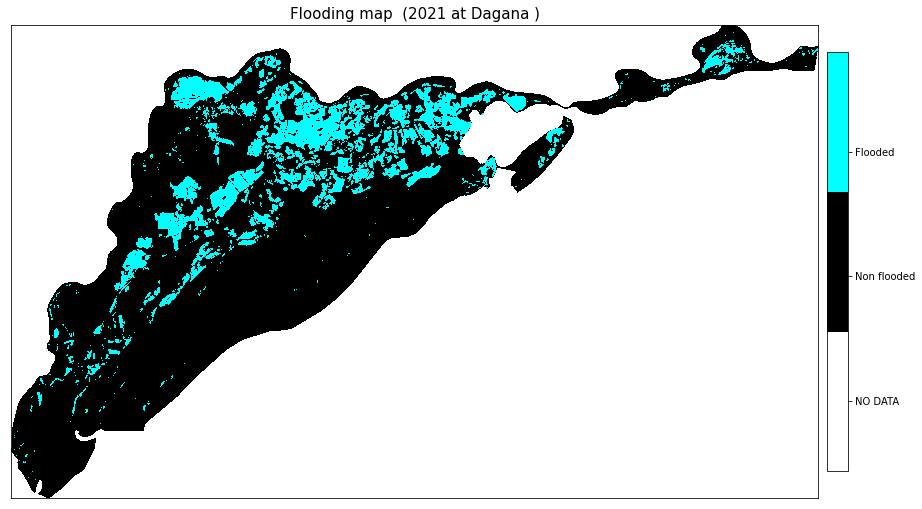

In [ ]:
# l = dates_str[1:]
#dfres =pd.read_csv (path+'/clean_cropped_irrigated.csv')

#t = dfres['period_cropped_prediction'].to_list()
#l1 = [i.split('TO')[1]. split('_')[1] for i in t ]

ls = ['NO DATA','Non flooded', 'Flooded'] 
# plot 
tic =[0,1, 2, 3,4,12] # np.linspace(0, 6, num=len(ls) , retstep=True)
tic  =[0.25, 1.5, 11]   #list(tic[0])
label = ls
arrplot = ras

#set colors for plotting and classes
col = ['white', 'black', 'orange', 'cyan']
#['white','orange','#00008b','blue','black']
cmap = matplotlib.colors.ListedColormap(col)
cmap.set_over('pink')
cmap.set_under('purple')
bounds = [0,0.5, 3, 31]  
norm = matplotlib.colors.BoundaryNorm (bounds, cmap.N)  

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(arrplot, cmap=cmap, norm = norm)
plt.title('Flooding map  (2021 at Dagana )', size=15)
cbar = fig.colorbar(cax, ax=ax, fraction=0.025, pad=0.01, ticks=tic)
cbar.ax.set_yticklabels(label)
#plt.savefig('/content/drive/MyDrive/Glorie/2022_work/dry_hot/maps/new/rice_map_irrigated.png', bbox_inches="tight") 
plt.show()
#plt.savefig(fname, bbox_inches="tight") 
        

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


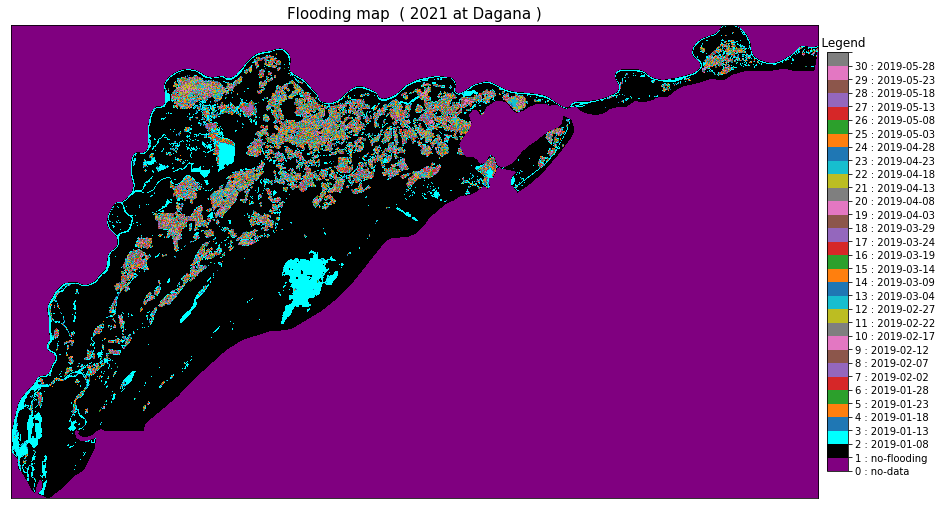

In [ ]:
import seaborn as sns
date_list =  [img_name.split('_')[1].split('.')[0]  for img_name in listcloud] 
dates ={}
c = 2
dates[0]= 'no-data'
dates[1]= 'no-flooding'
for d in date_list:
  dates[c] = d
  c+=1

list21 = []
for d in dates:
  list21.append(str(d) + ' : ' +dates[d] )

l = [0.5 + i for i in range(len(dates))]
palette = sns.color_palette(None, len(l) -3)



ls = ['NO DATA','Non flooded'] + date_list[1:]
# plot 
tic =[0,1, 2, 3,4,12] # np.linspace(0, 6, num=len(ls) , retstep=True)
tic  =[-1]+ l #[0.5, 2, 8.5]   #list(tic[0])
label = list21 #[-1]+ l
arrplot =  ras

#set colors for plotting and classes
col = ['purple', 'black', 'cyan'] + palette  #['white', 'black', 'orange', 'cyan']
#['white','orange','#00008b','blue','black']
cmap = matplotlib.colors.ListedColormap(col)
cmap.set_over('pink')
cmap.set_under('purple')
bounds = [-1]+ l  #[0,0.5, 3.5, 35]  
norm = matplotlib.colors.BoundaryNorm (bounds, cmap.N)  

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(arrplot, cmap=cmap, norm = norm)
plt.title('Flooding map  ( 2021 at Dagana )', size=15)
cbar = fig.colorbar(cax, ax=ax, fraction=0.025, pad=0.01, ticks=tic)
cbar.ax.set_yticklabels( label)
cbar.ax.set_title('    Legend ')
plt.savefig(pathim+'/2021/output/figures/maps_timeseries_2021.tif', bbox_inches="tight") 
plt.show()
#plt.savefig(fname, bbox_inches="tight") 
        

In [ ]:
pathi = '/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/data/images/hot_dry_season/dagana/2021/output/maps'
rgb_array = rasterio.open(pathi+'/test.tif').read(1)
r= rgb_array 

In [ ]:

arrayimg14 = r
res_set3 = list(set(i for j in arrayimg14 for i in j))
area =[]
val={}
for w in res_set3:
    x = arrayimg14[arrayimg14== w]
    #print('---------------')
    #print(w)
    #print(x.size)
    l= x.size*100*0.0001
    area.append(l)
    val[w] = l

    #print(l)
val

{0.0: 724416.54, 1.0: 276745.46}

In [ ]:
working_array =  r.copy()

In [ ]:

# working_array =  r.copy()
# for i in range(0,r.shape[0]):
#   for j in range(0,r.shape[1]):
#     if ras [i,j] == 2:
#         working_array[i,j] = 1
#     if ras [i,j] > 2:
#         working_array[i,j] = 3

# profile = rasterio.open('/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/data/images/hot_dry_season/dagana/2021/output/maps/test.tif', driver='Gtiff').profile
# with rasterio.open(pathim+'/2021/output/maps/maps_ajusted2021.tif', 'w', **profile) as dst:
#         dst.write(working_array.astype(rasterio.uint8), 1)

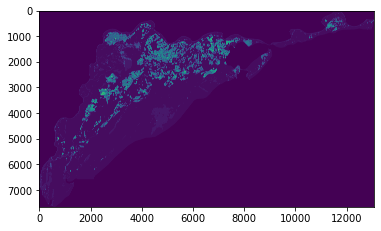

In [ ]:
plot.show(working_array)

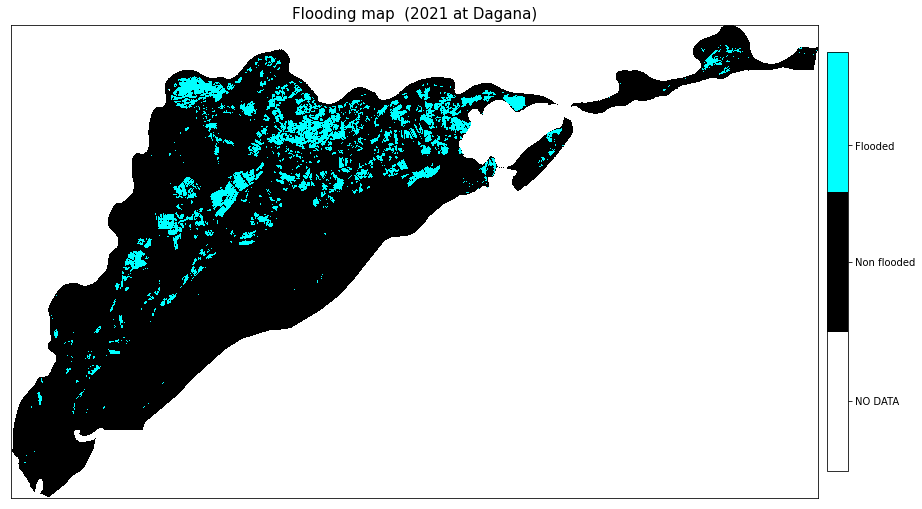

In [ ]:
# l = dates_str[1:]
#dfres =pd.read_csv (path+'/clean_cropped_irrigated.csv')

#t = dfres['period_cropped_prediction'].to_list()
#l1 = [i.split('TO')[1]. split('_')[1] for i in t ]

ls = ['NO DATA','Non flooded', 'Flooded'] 
# plot 
tic =[0,1, 2, 3,4,12] # np.linspace(0, 6, num=len(ls) , retstep=True)
tic  =[0.5, 1.25, 2]   #list(tic[0])
label = ls
arrplot =  working_array

#set colors for plotting and classes
col = ['white', 'black', 'orange', 'cyan']
#['white','orange','#00008b','blue','black']
cmap = matplotlib.colors.ListedColormap(col)
cmap.set_over('pink')
cmap.set_under('purple')
bounds = [0,1,1.5,3]  
norm = matplotlib.colors.BoundaryNorm (bounds, cmap.N)  

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(arrplot, cmap=cmap, norm = norm)
plt.title('Flooding map  (2021 at Dagana)', size=15)
cbar = fig.colorbar(cax, ax=ax, fraction=0.025, pad=0.01, ticks=tic)
cbar.ax.set_yticklabels(label)
#plt.savefig('/content/drive/MyDrive/Glorie/2022_work/dry_hot/maps/new/rice_map_irrigated.png', bbox_inches="tight") 
plt.show()
#plt.savefig(fname, bbox_inches="tight") 
        

In [ ]:
arrayimg14 = working_array
res_set3 = list(set(i for j in arrayimg14 for i in j))
area =[]
val={}
for w in res_set3:
    x = arrayimg14[arrayimg14== w]
    #print('---------------')
    #print(w)
    #print(x.size)
    l= x.size*100*0.0001
    area.append(l)
    val[w] = l

    #print(l)
val

{0.0: 724416.54, 1.0: 244705.07, 2.0: 32040.390000000003}

In [ ]:
l = [ '2021-01-01' ,'2021-01-11', '2021-01-21', '2021-02-01', '2021-02-11', '2021-02-21',
     '2021-03-01', '2021-03-11', '2021-03-21', '2021-04-01', '2021-04-11' ,'2021-04-21',
     '2021-05-01', '2021-05-11', '2021-05-21']
#dfres =pd.read_csv (path+'/clean_cropped_irrigated.csv')

#t = dfres['period_cropped_prediction'].to_list()
#l1 = [i.split('TO')[1]. split('_')[1] for i in t ]

ls = ['NO DATA','Non flooded']+ date_list[1:]
ls= ['NO DATA','Non flooded', '2022-01-07', '2022-01-12','2022-01-17','2022-01-22','2022-01-27','2022-02-01']
# plot 
#tic =np.linspace(0.5, 16, num=len(ls) , retstep=True)
tic =[0.5,  2, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5] #[ i for i in range(len(ls))]  #list(tic[0])
label = ls
arrplot =  arrayimg1
#set colors for plotting and classes
# col = ['white', 'gray','orange', 'pink' ,'purple','brown', 'red' , '#097969',
#       #  '#5F9EA0', '#AFE1AF',  '#00FF7F', '#7CFC00','yellow',# '#7CFC00', # '#DFFF00',  'yellow',  'yellow', 'yellow', 
#         ]
#['white','orange','#00008b','blue','black']
cmap = cool #matplotlib.colors.ListedColormap(col)
cmap.set_over('gray')
cmap.set_under('white')
bounds =  [0,1, 3,4,5, 6, 7, 8,  10] #list(range(len(ls))) #
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)  

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(arrplot, cmap=cmap, norm = norm)
plt.title('Spatial distribution of flooding dates (January 2022 at Dagana)', size=15)
cbar = fig.colorbar(cax, ax=ax, fraction=0.025, pad=0.01, ticks=tic)
cbar.ax.set_yticklabels(label)
#plt.savefig('/content/drive/MyDrive/Glorie/2022_work/dry_hot/maps/new/rice_map_irrigated_bydate_up_.png', bbox_inches="tight") 
plt.show()
#plt.savefig(fname, bbox_inches="tight") 
        

##2020

In [ ]:
ras20  = rasterio.open(pathim+'/2020/output/maps/flooding_maps2020_14.tif').read(1)

In [ ]:
l[]

In [ ]:

list21

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


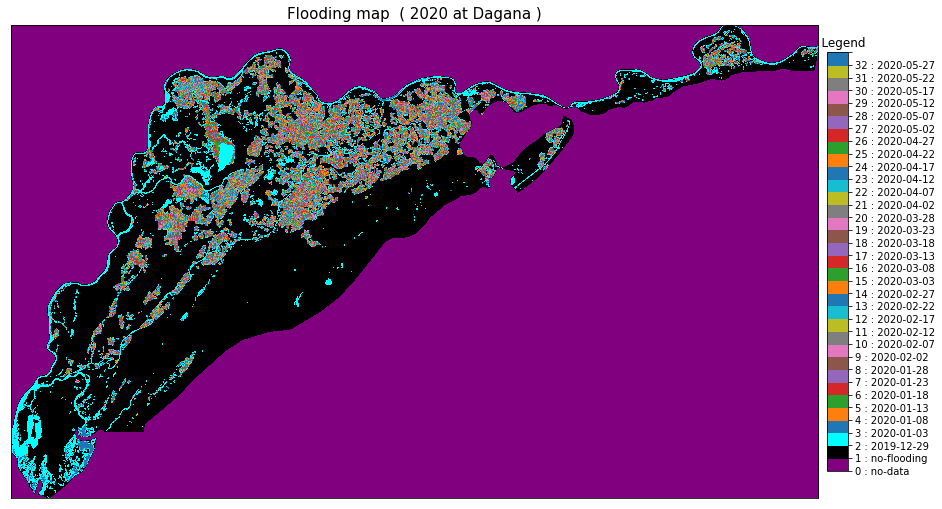

In [ ]:
import seaborn as sns
date_list =  [img_name.split('_')[1].split('.')[0]  for img_name in listcloud20] 
dates ={}
c = 2
dates[0]= 'no-data'
dates[1]= 'no-flooding'
for d in date_list:
  dates[c] = d
  c+=1

list21 = []
for d in dates:
  list21.append(str(d) + ' : ' +dates[d] )

l = [0.25 + i for i in range(len(dates))]
palette = sns.color_palette(None, len(l) -2)



ls = ['NO DATA','Non flooded'] + date_list[1:]
# plot 
tic =[0,1, 2, 3,4,12] # np.linspace(0, 6, num=len(ls) , retstep=True)
tic  =[-1] +l #[0.5, 2, 8.5]   #list(tic[0])
label = list21 #[-1]+ l
arrplot =  ras20

#set colors for plotting and classes
col = ['purple', 'black', 'cyan'] + palette  #['white', 'black', 'orange', 'cyan']
#['white','orange','#00008b','blue','black']
cmap = matplotlib.colors.ListedColormap(col)
cmap.set_over('pink')
cmap.set_under('purple')
bounds = [-1]+ l  #[0,0.5, 3.5, 35]  
norm = matplotlib.colors.BoundaryNorm (bounds, cmap.N)  

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(arrplot, cmap=cmap, norm = norm)
plt.title('Flooding map  ( 2020 at Dagana )', size=15)
cbar = fig.colorbar(cax, ax=ax, fraction=0.025, pad=0.01, ticks=tic)
cbar.ax.set_yticklabels( label)
cbar.ax.set_title('    Legend ')
plt.savefig(pathim+'/2020/output/figures/maps_timeseries_2020.tif', bbox_inches="tight") 
plt.show()
#plt.savefig(fname, bbox_inches="tight") 
        

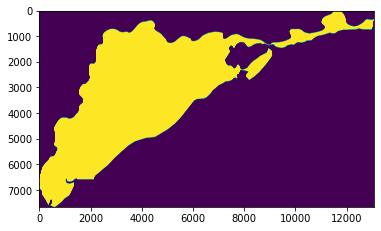

In [ ]:
plot.show(r)

In [ ]:

working_array20 =  r.copy()
for i in range(0,r.shape[0]):
  for j in range(0,r.shape[1]):
    if ras20 [i,j] == 2:
        working_array20[i,j] = 1
    if ras20 [i,j] > 2:
        working_array20[i,j] = 2]

profile = rasterio.open('/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/data/images/hot_dry_season/dagana/2021/output/maps/test.tif', driver='Gtiff').profile
with rasterio.open(pathim+'/2020/output/maps/maps_ajusted2020.tif', 'w', **profile) as dst:
        dst.write(working_array20.astype(rasterio.uint8), 1)

In [ ]:
working_array20 = rasterio.open(pathim+'/2020/output/maps/maps_ajusted2020.tif').read(1)

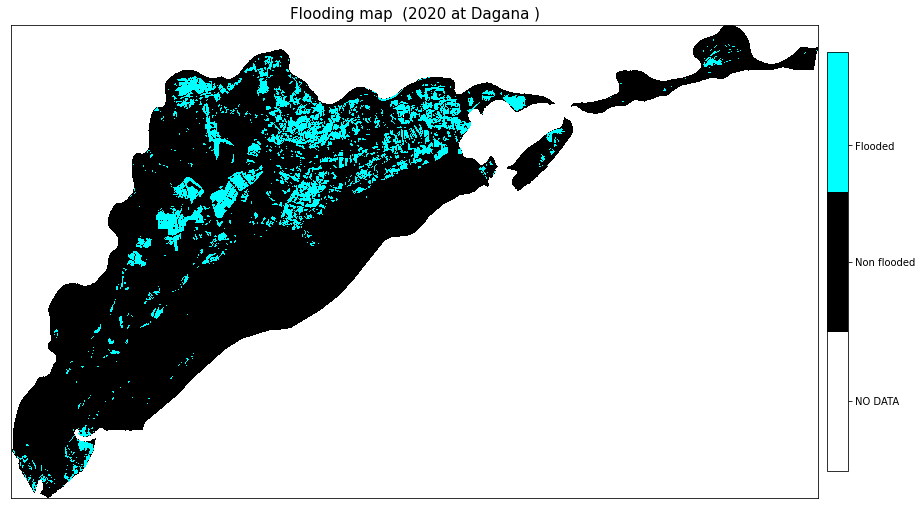

In [ ]:
# l = dates_str[1:]
#dfres =pd.read_csv (path+'/clean_cropped_irrigated.csv')

#t = dfres['period_cropped_prediction'].to_list()
#l1 = [i.split('TO')[1]. split('_')[1] for i in t ]

ls = ['NO DATA','Non flooded', 'Flooded'] 
# plot 
tic =[0,1, 2, 3,4,12] # np.linspace(0, 6, num=len(ls) , retstep=True)
tic  =[0.5, 1.25, 2]    #list(tic[0])
label = ls
arrplot =  working_array20

#set colors for plotting and classes
col = ['white', 'black', 'orange', 'cyan']
#['white','orange','#00008b','blue','black']
cmap = matplotlib.colors.ListedColormap(col)
cmap.set_over('pink')
cmap.set_under('purple')
bounds = [0,1, 1.5, 3]  
norm = matplotlib.colors.BoundaryNorm (bounds, cmap.N)  

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(arrplot, cmap=cmap, norm = norm)
plt.title('Flooding map  (2020 at Dagana )', size=15)
cbar = fig.colorbar(cax, ax=ax, fraction=0.025, pad=0.01, ticks=tic)
cbar.ax.set_yticklabels(label)
#plt.savefig('/content/drive/MyDrive/Glorie/2022_work/dry_hot/maps/new/rice_map_irrigated.png', bbox_inches="tight") 
plt.show()
#plt.savefig(fname, bbox_inches="tight") 
        

In [ ]:
arrayimg14 = ras20
res_set3 = list(set(i for j in arrayimg14 for i in j))
area =[]
val={}
for w in res_set3:
    x = arrayimg14[arrayimg14== w]
    #print('---------------')
    #print(w)
    #print(x.size)
    l= x.size*100*0.0001
    area.append(l)
    val[w] = l

    #print(l)
val

{0.0: 724416.54,
 1.0: 227754.59,
 2.0: 11914.050000000001,
 3.0: 2325.13,
 4.0: 1289.77,
 5.0: 1233.42,
 6.0: 419.65000000000003,
 7.0: 126.32000000000001,
 8.0: 266.05,
 9.0: 745.12,
 10.0: 588.75,
 11.0: 320.67,
 12.0: 125.74000000000001,
 13.0: 4102.54,
 14.0: 3960.13,
 15.0: 2665.26,
 16.0: 2111.17,
 17.0: 3514.2400000000002,
 18.0: 3177.31,
 19.0: 2445.44,
 20.0: 4.58,
 21.0: 5239.34,
 22.0: 915.7700000000001,
 23.0: 168.77,
 24.0: 93.08,
 25.0: 481.94,
 26.0: 318.93,
 27.0: 17.76,
 28.0: 213.17000000000002,
 29.0: 22.220000000000002,
 30.0: 97.0,
 31.0: 52.59,
 32.0: 34.96}

In [ ]:
sum(area) - area[0]-area[1] -area[2]

37076.82000000008

## 2019

In [ ]:
ras19  = rasterio.open (pathim+'/2019/output/maps/flooding_maps2019_14.tif').read(1)

In [ ]:
len(l)

In [ ]:

import seaborn as sns
date_list =  [img_name.split('_')[1].split('.')[0]  for img_name in listcloud] 
dates ={}
c = 2
dates[0]= 'no-data'
dates[1]= 'no-flooding'
for d in date_list:
  dates[c] = d
  c+=1

list21 = []
for d in dates:
  list21.append(str(d) + ' : ' +dates[d] )

l = [0.5 + i for i in range(len(dates))]
palette = sns.color_palette(None, len(l) -3)

31

In [ ]:
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


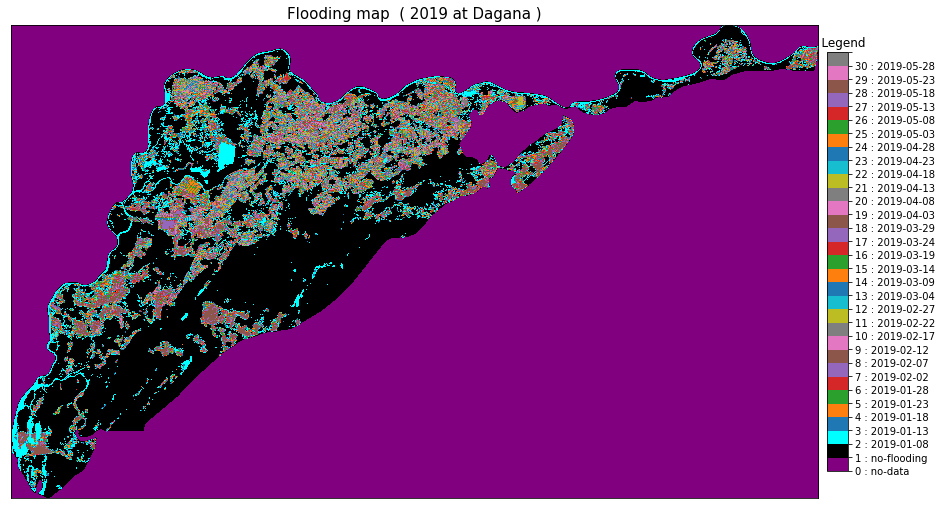

In [ ]:
import seaborn as sns
date_list =  [img_name.split('_')[1].split('.')[0]  for img_name in listcloud19] 
dates ={}
c = 2
dates[0]= 'no-data'
dates[1]= 'no-flooding'
for d in date_list:
  dates[c] = d
  c+=1

list21 = []
for d in dates:
  list21.append(str(d) + ' : ' +dates[d] )

l = [0.5 + i for i in range(len(dates))]
palette = sns.color_palette(None, len(l) -3)



ls = ['NO DATA','Non flooded'] + date_list[1:]
# plot 
tic =[0,1, 2, 3,4,12] # np.linspace(0, 6, num=len(ls) , retstep=True)
tic  =[-1]+ l #[0.5, 2, 8.5]   #list(tic[0])
label = list21 #[-1]+ l
arrplot =  ras19

#set colors for plotting and classes
col = ['purple', 'black', 'cyan'] + palette  #['white', 'black', 'orange', 'cyan']
#['white','orange','#00008b','blue','black']
cmap = matplotlib.colors.ListedColormap(col)
cmap.set_over('pink')
cmap.set_under('purple')
bounds = [-1]+ l  #[0,0.5, 3.5, 35]  
norm = matplotlib.colors.BoundaryNorm (bounds, cmap.N)  

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(arrplot, cmap=cmap, norm = norm)
plt.title('Flooding map  ( 2019 at Dagana )', size=15)
cbar = fig.colorbar(cax, ax=ax, fraction=0.025, pad=0.01, ticks=tic)
cbar.ax.set_yticklabels( label)
cbar.ax.set_title('    Legend ')
plt.savefig(pathim+'/2019/output/figures/maps_timeseries_2019.tif', bbox_inches="tight") 
plt.show()
#plt.savefig(fname, bbox_inches="tight") 
        

In [ ]:
working_array19 =  r.copy()
for i in range(0,r.shape[0]):
  for j in range(0,r.shape[1]):
    if ras19 [i,j] == 2:
        working_array19[i,j] = 1
    if ras19 [i,j] > 2:
        working_array19[i,j] = 2

In [ ]:
profile = rasterio.open('/content/drive/WORK/SCIENTIFIC_OFFICER-ICRISAT/Biophysical folder/Glorie/2022_work/data/images/hot_dry_season/dagana/2021/output/maps/test.tif', driver='Gtiff').profile
with rasterio.open(pathim+'/2019/output/maps/maps_ajusted2019.tif', 'w', **profile) as dst:
        dst.write(working_array19.astype(rasterio.uint8), 1)

In [ ]:
working_array19 = rasterio.open(pathim+'/2019/output/maps/maps_ajusted2019.tif').read(1)

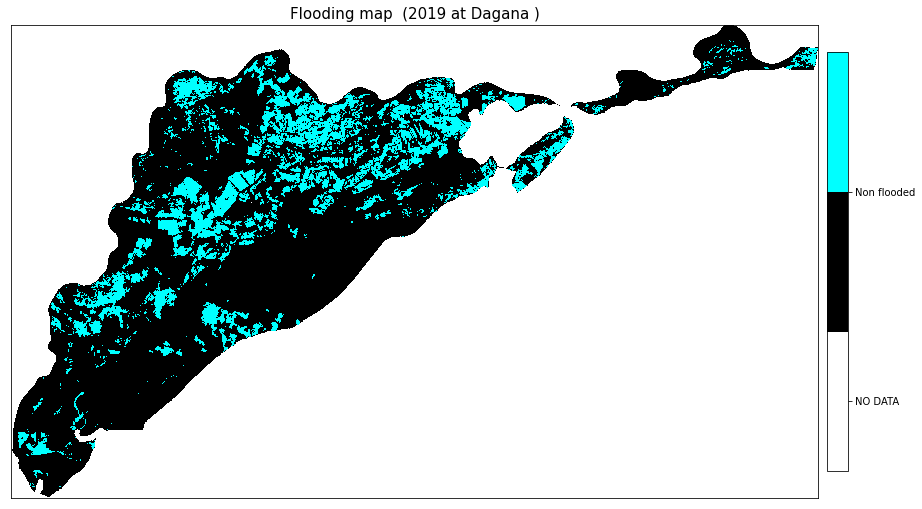

In [ ]:
# l = dates_str[1:]
#dfres =pd.read_csv (path+'/clean_cropped_irrigated.csv')

#t = dfres['period_cropped_prediction'].to_list()
#l1 = [i.split('TO')[1]. split('_')[1] for i in t ]

ls = ['NO DATA','Non flooded', 'Flooded'] 
# plot 
tic =[0,1, 2, 3,4,12] # np.linspace(0, 6, num=len(ls) , retstep=True)
tic  =[0.5, 1.5, 13]   #list(tic[0])
label = ls
arrplot =  working_array19

#set colors for plotting and classes
col = ['white', 'black', 'orange', 'cyan']
#['white','orange','#00008b','blue','black']
cmap = matplotlib.colors.ListedColormap(col)
cmap.set_over('pink')
cmap.set_under('purple')
bounds = [0,1, 1.5, 3]  
norm = matplotlib.colors.BoundaryNorm (bounds, cmap.N)  

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(arrplot, cmap=cmap, norm = norm)
plt.title('Flooding map  (2019 at Dagana )', size=15)
cbar = fig.colorbar(cax, ax=ax, fraction=0.025, pad=0.01, ticks=tic)
cbar.ax.set_yticklabels(label)
#plt.savefig('/content/drive/MyDrive/Glorie/2022_work/dry_hot/maps/new/rice_map_irrigated.png', bbox_inches="tight") 
plt.show()
#plt.savefig(fname, bbox_inches="tight") 
        

In [ ]:
c =zonal_stats(grid_path,pathim +'/202/cloud/'+ listcloud[0]) 

In [ ]:
pd.DataFrame(c)['count']

In [ ]:
df

In [ ]:
df = georead1.copy()
path_ =  pathim +'/2021/cloud/'
count_ref_img0 =zonal_stats(grid_path,path_+ listcloud[0]) 
size = pd.DataFrame(count_ref_img0)['count']
df['total_size'] = size
for img_name in  listcloud:
  date = img_name.split('_')[1].split('.')[0]
  pim = path_ +img_name
  count_ref_img1 =zonal_stats(grid_path,pim,categorical=True)
  stat_df=pd.DataFrame(count_ref_img1)
  stat_df= stat_df.fillna(0)
  thresh = [i for i in stat_df.columns.to_list() if i < 40]
  df[date] = stat_df[thresh] .sum(axis=1)


In [ ]:
df

In [ ]:
dates = [img_name.split('_')[1].split('.')[0]  for img_name in listcloud[1:]]

In [ ]:
dates

In [ ]:
*100*0.0001

In [ ]:
df1 = df[['total_size']]

In [ ]:
df1 = georead1.copy()

In [ ]:
dfr[dates] 

In [ ]:
for d in dates:
  df1[d]= df1['total_size']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df[dates]/df1[dates] *100


In [ ]:

df1 ['total_size'] *100*0.0001

NameError: ignored

In [ ]:
dfr[dates] / 